In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [27]:
# set the initial state

x = -1.0
z = 1.5

x_dot = 0.0
z_dot = 0.0

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -5.0

# time of simulation (number of seconds)
time_of_sim = 2.0


state_initial = (x,0.,z,0.,0.,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot)

Num states: 14
Spawning PlanarRigidBodyVisualizer for tree with 1 actuators


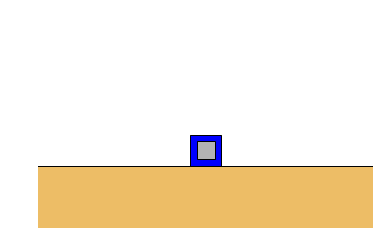

In [28]:
timestep = 0.0
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree, timestep)
nx = tree.get_num_positions() + tree.get_num_velocities()
print("Num states: {}".format(nx))

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

plant_context = plant.CreateDefaultContext()

robot = builder.AddSystem(plant)

torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

# what do xlim and ylim mean, what about -5 for the ground element
vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

# And also log
signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(False)

In [29]:
context = simulator.get_mutable_context()
state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector(state_initial)
simulator.StepTo(time_of_sim)

In [30]:
ani = vis.animate(signalLogger, repeat=True)
HTML(ani.to_html5_video())

In [25]:
# set some initial conditions and parameters

# time constraints
minimum_time = 0.0
maximal_time = time_of_sim


# solve for the trajectory and input I wish to achieve
mp = MathematicalProgram()

# number knot points
N = 50

time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used

dt = time_used/(N+1)

u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
u_over_time = u

for k in range(1,N):
    u = mp.NewContinuousVariables(1, "u_%d" % k)
    u_over_time = np.vstack((u_over_time, u))
total_u = u_over_time

# create x variables
x = mp.NewContinuousVariables(14, "x_%d" % 0) # for both input thrusters
x_over_time = x
for k in range(1,N+1):
    x = mp.NewContinuousVariables(14, "x_%d" % k)
    x_over_time = np.vstack((x_over_time, x))
total_x = x_over_time

# add x constraints
error_thresh = 0.001
for n in range(N):
    state_next = total_x[n+1]
    #TODO change the dynamics here
    dynamic_state_next = total_x[n,:] + self.rocket_dynamics(total_x[n,:], total_u[n,:])*dt
    # add constraint for each state
    for j in range(14):
        state_error = state_next[j] - dynamic_state_next[j]
        mp.AddConstraint(state_error <= error_thresh)
        mp.AddConstraint(state_error >= -error_thresh)
        
        
# add the cost
mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))


# add constraint
mp.AddConstraint(perp_error == 0.0)

for i in range(14):
    initial_state_error = x_over_time[0,i] - st
    ate_initial[i]
    mp.AddConstraint(initial_state_error == 0.0)
    
# add time constraint
mp.AddConstraint(time_used[0] >= minimum_time)
mp.AddConstraint(time_used[0] <= maximum_time)

print "Number of decision vars", mp.num_vars()
print(mp.Solve())

trajectory = mp.GetSolution(x_over_time)
input_trajectory = mp.GetSolution(u_over_time)
t = mp.GetSolution(time_used)
time_array = np.arange(0.0, t, t/(N+1))